# Mask generation with image coordinates

1. Define input image and the mask

In [1]:
from PIL import Image

input_path = '../inputs/inpainting/beach.png'
input_image = Image.open(input_path)

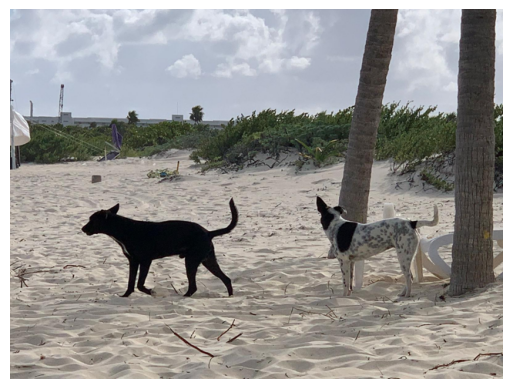

In [2]:
from matplotlib import pyplot as plt

plt.imshow(input_image)
plt.axis('off')
plt.show()

In [3]:
coord_input_text = "200, 300; 480, 290"

In [4]:
input_points = None

if coord_input_text is not None:
    try:
        points = coord_input_text.split(';')
        input_points = []
        for point in points:
            x, y = map(int, point.split(',')) # Split by comma to get x and y coordinates
            input_points.append([x, y])
        input_points = [input_points] # Wrap input_points in another list to match the expected format e.g. [[[515,575],[803,558],[1684,841]]]
    except ValueError:
        print("Invalid input format for coordinates (expected: x1,y1;x2,y2;x3,y3)")
        input_points = None

input_image = input_image.convert("RGB")
print('input points:', input_points)

input points: [[[200, 300], [480, 290]]]


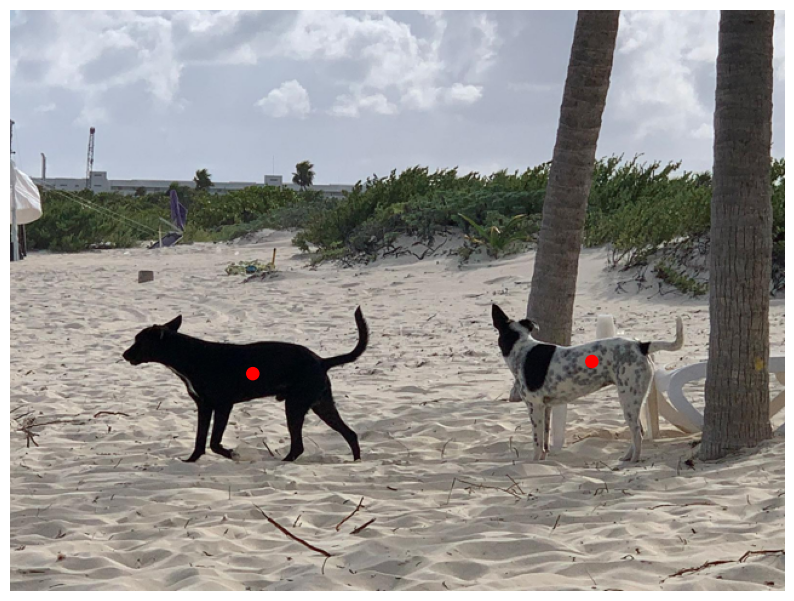

In [5]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Display the image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(input_image)

# Draw points on the image
for x, y in input_points[0]:
    ellipse = patches.Ellipse((x, y), width=10, height=10, edgecolor='red', facecolor='red')
    ax.add_patch(ellipse)

# Hide the axis
ax.axis('off')

# Show the plot
plt.show()

Load the SAM model (use facebook/sam-vit-base checkpoint)

In [14]:
import torch
from transformers import SamModel, SamProcessor


device = "cuda" if torch.cuda.is_available() else "cpu"
print('device:', device)
model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

device: cuda


Infer the model and select the mask with the highest IoU score

In [15]:
import numpy as np

inputs = processor(input_image, input_points=input_points, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
)
scores = outputs.iou_scores
masks = masks[0].squeeze(0)
max_index = torch.argmax(scores)
best_mask = masks[max_index]
    
output = best_mask

image_array = np.where(output, 255, 0).astype(np.uint8)
mask_image = Image.fromarray(image_array)

Visualise the output mask

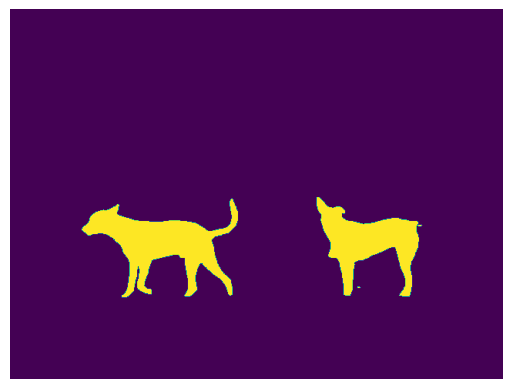

In [16]:
plt.imshow(mask_image)
plt.axis('off')
plt.show()

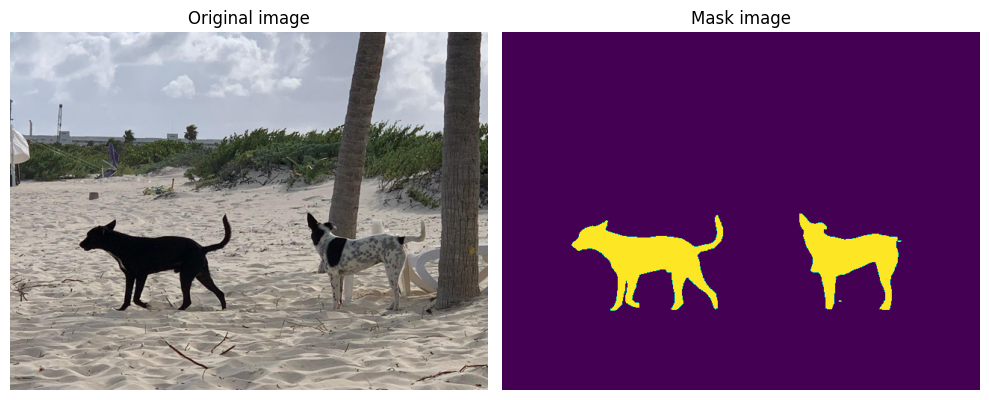

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(input_image)
axs[0].axis('off')  # Hide the axis
axs[0].set_title('Original image')  # Optionally set a title

# Display the second image in the right subplot
axs[1].imshow(mask_image)
axs[1].axis('off')  # Hide the axis
axs[1].set_title('Mask image')  # Optionally set a title

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()